# Lib

In [1]:
from PIL import Image
from transformers import AutoModelForObjectDetection
from transformers import TableTransformerForObjectDetection
import torch
from torchvision import transforms

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Patch

from PIL import ImageDraw

# Utils


In [2]:
# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(-1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h), (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)
def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b
def outputs_to_objects(outputs, img_size, id2label):
    m = outputs.logits.softmax(-1).max(-1)
    pred_labels = list(m.indices.detach().cpu().numpy())[0]
    pred_scores = list(m.values.detach().cpu().numpy())[0]
    pred_bboxes = outputs['pred_boxes'].detach().cpu()[0]
    pred_bboxes = [elem.tolist() for elem in rescale_bboxes(pred_bboxes, img_size)]
    objects = []
    for label, score, bbox in zip(pred_labels, pred_scores, pred_bboxes):
        class_label = id2label[int(label)]
        if not class_label == 'no object':
            objects.append({'label': class_label, 'score': float(score), 'bbox': [float(elem) for elem in bbox]})
    return objects

In [3]:
class MaxResize(object):
    def __init__(self, max_size=800):
        self.max_size = max_size
    def __call__(self, image):
        width, height = image.size
        current_max_size = max(width, height)
        scale = self.max_size / current_max_size
        resized_image = image.resize((int(round(scale*width)), int(round(scale*height))))
        return resized_image

# Table detection

## src


In [4]:
def objects_to_crops(img, tokens, objects, class_thresholds, padding=10):
    table_crops = []
    for obj in objects:
        if obj['score'] < class_thresholds[obj['label']]:
            continue
        cropped_table = {}
        bbox = obj['bbox']
        bbox = [bbox[0]-padding, bbox[1]-padding, bbox[2]+padding, bbox[3]+padding]
        cropped_img = img.crop(bbox)
        table_tokens = [token for token in tokens if iob(token['bbox'], bbox) >= 0.5]
        for token in table_tokens:
            token['bbox'] = [token['bbox'][0]-bbox[0],
                             token['bbox'][1]-bbox[1],
                             token['bbox'][2]-bbox[0],
                             token['bbox'][3]-bbox[1]]
        if obj['label'] == 'table rotated':
            cropped_img = cropped_img.rotate(270, expand=True)
            for token in table_tokens:
                bbox = token['bbox']
                bbox = [cropped_img.size[0]-bbox[3]-1,
                        bbox[0],
                        cropped_img.size[0]-bbox[1]-1,
                        bbox[2]]
                token['bbox'] = bbox
        cropped_table['image'] = cropped_img
        #cropped_table['tokens'] = table_tokens
        table_crops.append(cropped_table)
    return table_crops

In [5]:
def fig2img(fig):
    """Convert a Matplotlib figure to a PIL Image and return it"""
    import io
    buf = io.BytesIO()
    fig.savefig(buf)
    buf.seek(0)
    img = Image.open(buf)
    return img
def visualize_detected_tables(img, det_tables, out_path=None):
    plt.imshow(img, interpolation="lanczos")
    fig = plt.gcf()
    fig.set_size_inches(20, 20)
    ax = plt.gca()
    for det_table in det_tables:
        bbox = det_table['bbox']
        if det_table['label'] == 'table':
            facecolor = (1, 0, 0.45)
            edgecolor = (1, 0, 0.45)
            alpha = 0.3
            linewidth = 2
            hatch='//////'
        elif det_table['label'] == 'table rotated':
            facecolor = (0.95, 0.6, 0.1)
            edgecolor = (0.95, 0.6, 0.1)
            alpha = 0.3
            linewidth = 2
            hatch='//////'
        else:
            continue
        rect = patches.Rectangle(bbox[:2], bbox[2]-bbox[0], bbox[3]-bbox[1], linewidth=linewidth, edgecolor='none', facecolor=facecolor, alpha=0.1)
        ax.add_patch(rect)
        rect = patches.Rectangle(bbox[:2], bbox[2]-bbox[0], bbox[3]-bbox[1], linewidth=linewidth, edgecolor=edgecolor, facecolor='none',linestyle='-', alpha=alpha)
        ax.add_patch(rect)
        rect = patches.Rectangle(bbox[:2], bbox[2]-bbox[0], bbox[3]-bbox[1], linewidth=0, edgecolor=edgecolor, facecolor='none', linestyle='-', hatch=hatch, alpha=0.2)
        ax.add_patch(rect)
    plt.xticks([], [])
    plt.yticks([], [])
    legend_elements = [Patch(facecolor=(1, 0, 0.45), edgecolor=(1, 0, 0.45), label='Table', hatch='//////', alpha=0.3),                      Patch(facecolor=(0.95, 0.6, 0.1), edgecolor=(0.95, 0.6, 0.1),                               label='Table (rotated)', hatch='//////', alpha=0.3)]
    plt.legend(handles=legend_elements, bbox_to_anchor=(0.5, -0.02), loc='upper center', borderaxespad=0, fontsize=10, ncol=2)
    plt.gcf().set_size_inches(10, 10)
    plt.axis('off')
    if out_path is not None:
      plt.savefig(out_path, bbox_inches='tight', dpi=150)
    return fig

## main

In [9]:
detection_model = AutoModelForObjectDetection.from_pretrained("microsoft/table-transformer-detection", revision="no_timm")
# update id2label to include "no object"
id2label = detection_model.config.id2label
id2label[len(detection_model.config.id2label)] = "no object"

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"
detection_model.to(device)
print("")

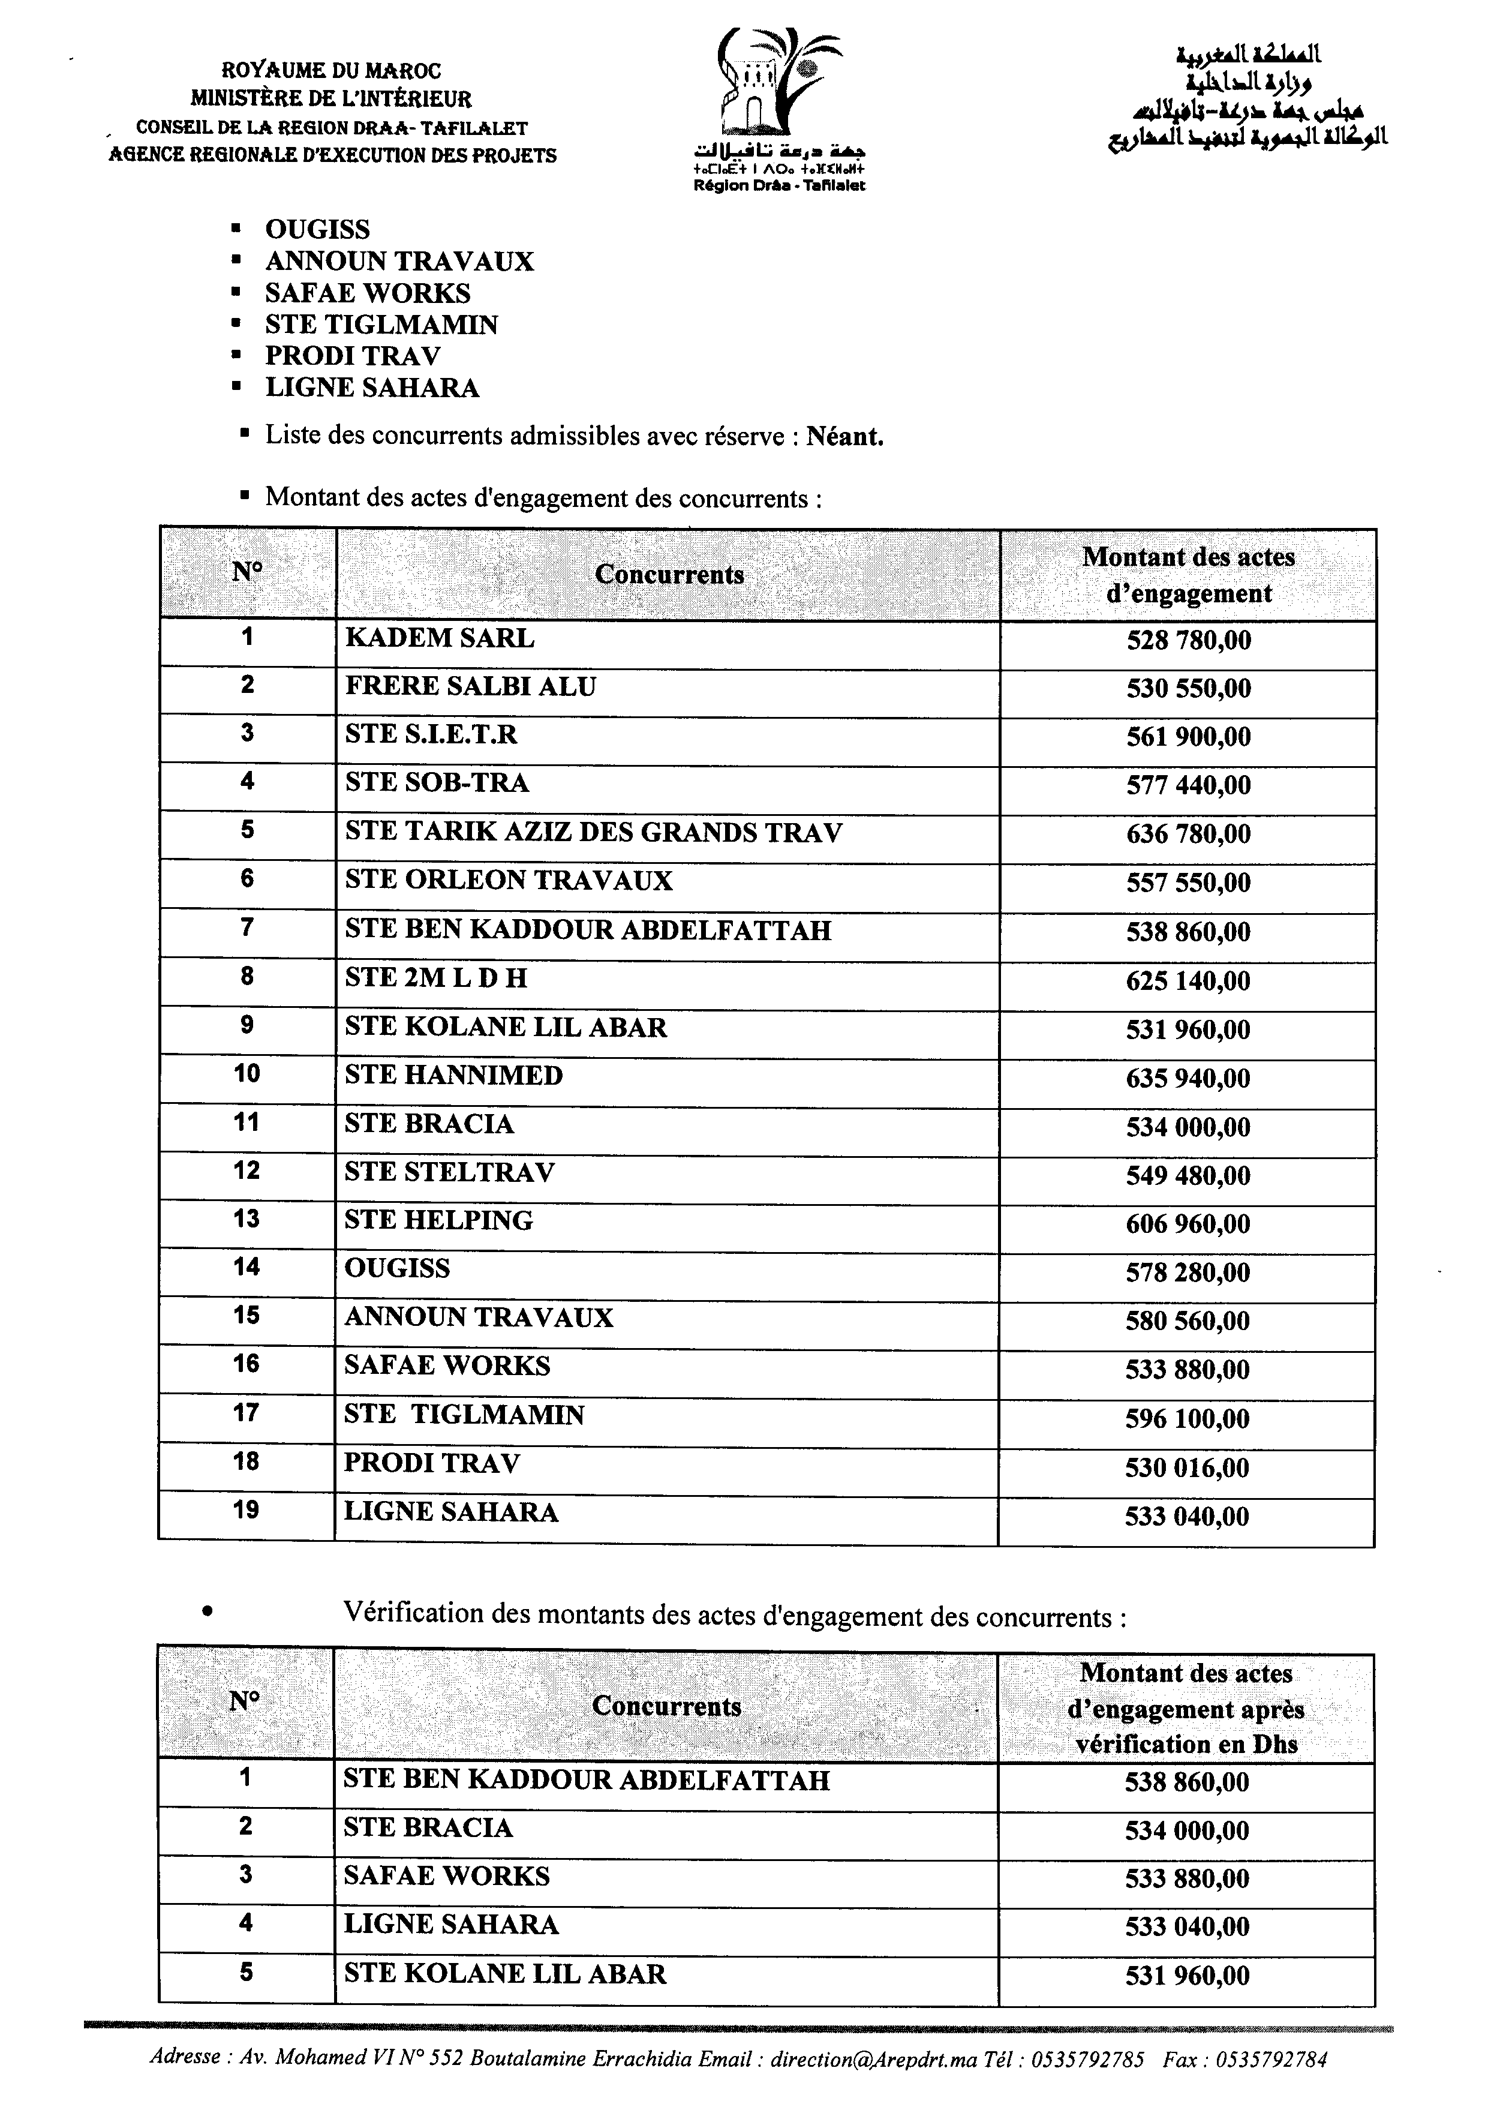

In [11]:
file_path = "../documents/png.png"
image = Image.open(file_path).convert("RGB")
# let's display it a bit smaller
width, height = image.size
display(image.resize((int(0.6*width), (int(0.6*height)))))

In [12]:
detection_transform = transforms.Compose([
    MaxResize(800),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [13]:
pixel_values = detection_transform(image).unsqueeze(0)
pixel_values = pixel_values.to(device)
print(pixel_values.shape)

torch.Size([1, 3, 800, 568])


In [14]:
with torch.no_grad():
  outputs = detection_model(pixel_values)

In [15]:
objects = outputs_to_objects(outputs, image.size, id2label)
print(objects)

[{'label': 'table', 'score': 0.998571515083313, 'bbox': [369.443115234375, 901.3762817382812, 2165.287353515625, 2541.086181640625]}, {'label': 'table', 'score': 0.9805678725242615, 'bbox': [370.9904479980469, 2780.439208984375, 2180.213623046875, 3334.585205078125]}]


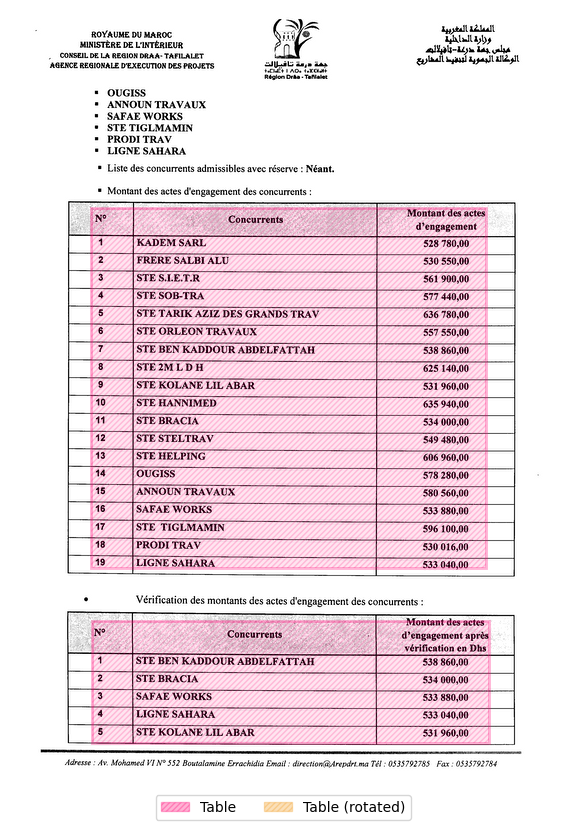

In [16]:
fig = visualize_detected_tables(image, objects)
visualized_image = fig2img(fig)

In [17]:
tokens = []
detection_class_thresholds = {
    "table": 0.5,
    "table rotated": 0.5,
    "no object": 10
}
crop_padding = 10
tables_crops = objects_to_crops(image, tokens, objects, detection_class_thresholds, padding=0)
cropped_table = tables_crops[0]['image'].convert("RGB")
cropped_table
cropped_table.save("table.jpg")

# Table structure recognition.

## src

In [20]:
def get_cell_coordinates_by_row(table_data):
    # Extract rows and columns
    rows = [entry for entry in table_data if entry['label'] == 'table row']
    columns = [entry for entry in table_data if entry['label'] == 'table column']
    # Sort rows and columns by their Y and X coordinates, respectively
    rows.sort(key=lambda x: x['bbox'][1])
    columns.sort(key=lambda x: x['bbox'][0])
    # Function to find cell coordinates
    def find_cell_coordinates(row, column):
        cell_bbox = [column['bbox'][0], row['bbox'][1], column['bbox'][2], row['bbox'][3]]
        return cell_bbox
    # Generate cell coordinates and count cells in each row
    cell_coordinates = []
    for row in rows:
        row_cells = []
        for column in columns:
            cell_bbox = find_cell_coordinates(row, column)
            row_cells.append({'column': column['bbox'], 'cell': cell_bbox})
        # Sort cells in the row by X coordinate
        row_cells.sort(key=lambda x: x['column'][0])
        # Append row information to cell_coordinates
        cell_coordinates.append({'row': row['bbox'], 'cells': row_cells, 'cell_count': len(row_cells)})
    # Sort rows from top to bottom
    cell_coordinates.sort(key=lambda x: x['row'][1])
    return cell_coordinates

In [21]:
def plot_results(cells, class_to_visualize):
    if class_to_visualize not in structure_model.config.id2label.values():
      raise ValueError("Class should be one of the available classes")
    plt.figure(figsize=(16,10))
    plt.imshow(cropped_table)
    ax = plt.gca()
    for cell in cells:
        score = cell["score"]
        bbox = cell["bbox"]
        label = cell["label"]
        if label == class_to_visualize:
          xmin, ymin, xmax, ymax = tuple(bbox)
          ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, color="red", linewidth=3))
          text = f'{cell["label"]}: {score:0.2f}'
          ax.text(xmin, ymin, text, fontsize=15, bbox=dict(facecolor='yellow', alpha=0.5))
          plt.axis('off')


## main

In [22]:
# new v1.1 checkpoints require no timm anymore
structure_model = TableTransformerForObjectDetection.from_pretrained("microsoft/table-structure-recognition-v1.1-all")
structure_model.to(device)
print("")

config.json:   0%|          | 0.00/76.8k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/115M [00:00<?, ?B/s]

In [23]:
structure_transform = transforms.Compose([
    MaxResize(1000),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

pixel_values = structure_transform(cropped_table).unsqueeze(0)
pixel_values = pixel_values.to(device)
print(pixel_values.shape)

# forward pass
with torch.no_grad():
  outputs = structure_model(pixel_values)

torch.Size([1, 3, 913, 1000])


In [24]:
structure_id2label = structure_model.config.id2label
structure_id2label[len(structure_id2label)] = "no object"
cells = outputs_to_objects(outputs, cropped_table.size, structure_id2label)
print(cells)

[{'label': 'table column', 'score': 0.9991031885147095, 'bbox': [166.28201293945312, 5.072966575622559, 1207.8336181640625, 1641.126708984375]}, {'label': 'table row', 'score': 0.993893027305603, 'bbox': [13.32375717163086, 281.98699951171875, 1791.6759033203125, 364.8655090332031]}, {'label': 'table row', 'score': 0.9909900426864624, 'bbox': [13.619856834411621, 609.0366821289062, 1791.92919921875, 691.4838256835938]}, {'label': 'table row', 'score': 0.9584702253341675, 'bbox': [13.206537246704102, 121.60358428955078, 1791.9849853515625, 203.2139892578125]}, {'label': 'table column', 'score': 0.9882302284240723, 'bbox': [1238.91357421875, 3.767005205154419, 1792.7369384765625, 1639.748046875]}, {'label': 'table row', 'score': 0.9955456256866455, 'bbox': [13.451949119567871, 1087.47265625, 1791.9036865234375, 1168.139892578125]}, {'label': 'table column header', 'score': 0.9441511034965515, 'bbox': [13.428772926330566, 4.226370811462402, 1791.473876953125, 121.28654479980469]}, {'label

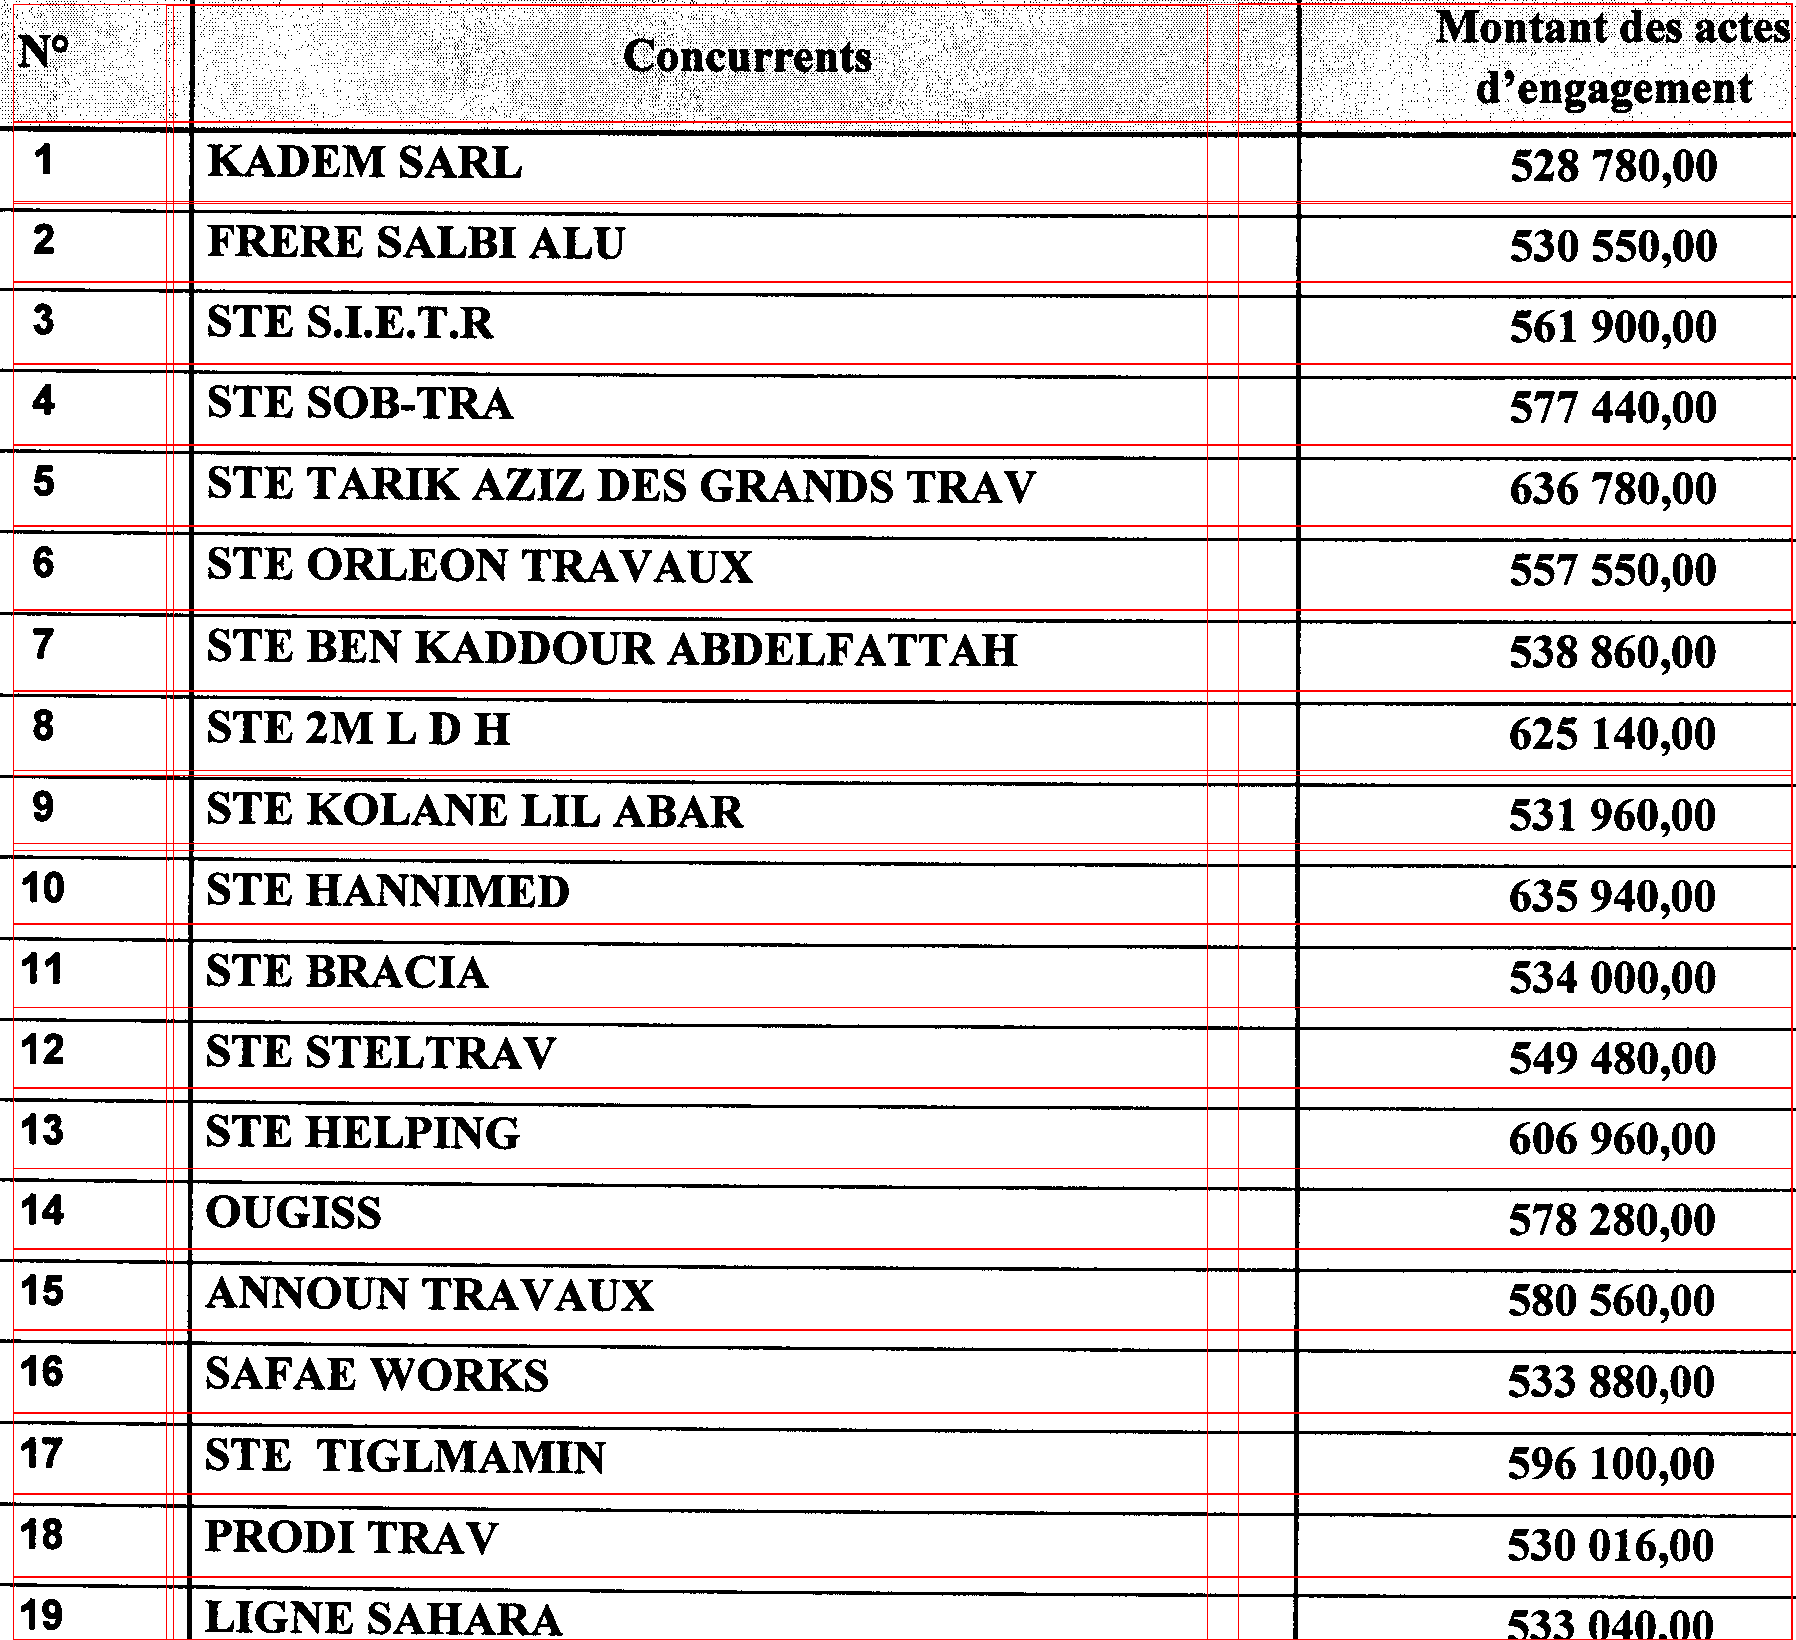

In [25]:
cropped_table_visualized = cropped_table.copy()
draw = ImageDraw.Draw(cropped_table_visualized)
for cell in cells:
    draw.rectangle(cell["bbox"], outline="red")
cropped_table_visualized

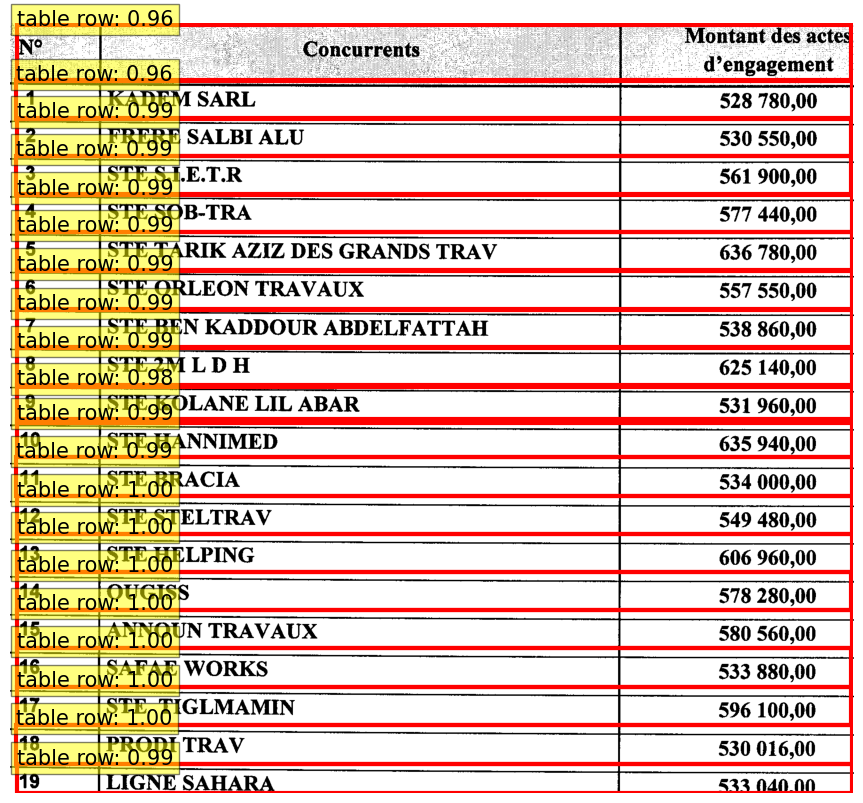

In [26]:
plot_results(cells, class_to_visualize="table row")

In [27]:
cell_coordinates = get_cell_coordinates_by_row(cells)
for row in cell_coordinates:
  print(row["cells"])

[{'column': [13.5462064743042, 4.613094329833984, 173.468017578125, 1639.010498046875], 'cell': [13.5462064743042, 4.6290459632873535, 173.468017578125, 122.44401550292969]}, {'column': [166.28201293945312, 5.072966575622559, 1207.8336181640625, 1641.126708984375], 'cell': [166.28201293945312, 4.6290459632873535, 1207.8336181640625, 122.44401550292969]}, {'column': [1238.91357421875, 3.767005205154419, 1792.7369384765625, 1639.748046875], 'cell': [1238.91357421875, 4.6290459632873535, 1792.7369384765625, 122.44401550292969]}]
[{'column': [13.5462064743042, 4.613094329833984, 173.468017578125, 1639.010498046875], 'cell': [13.5462064743042, 121.60358428955078, 173.468017578125, 203.2139892578125]}, {'column': [166.28201293945312, 5.072966575622559, 1207.8336181640625, 1641.126708984375], 'cell': [166.28201293945312, 121.60358428955078, 1207.8336181640625, 203.2139892578125]}, {'column': [1238.91357421875, 3.767005205154419, 1792.7369384765625, 1639.748046875], 'cell': [1238.91357421875, 

In [28]:
num_rows = len(cell_coordinates)
num_columns = len(cell_coordinates[0]["cells"])

In [29]:
num_rows

20

In [30]:
num_columns

3

# apply ocr

## lib

In [31]:
!pip install -q easyocr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 46.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 441.5 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 908.3/908.3 kB 28.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.3/281.3 kB 14.0 MB/s eta 0:00:00


In [32]:
!apt-get install -y tesseract-ocr

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 45 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 6s (844 kB/s)
Selecting previously unselected package tesseract-ocr-eng.
(Reading database ... 123594 files and directories currently installed.)
Preparing to unpack .../tesseract-ocr-en

In [33]:
pip install opencv-python-headless pytesseract

In [34]:
import numpy as np
import cv2
import csv
import easyocr
import pytesseract

In [35]:

reader = easyocr.Reader(['en']) # this needs to run only once to load the model into memory

Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete

## src

In [38]:
def apply_ocr(cell_coordinates):
    # let's OCR row by row
    data = dict()
    max_num_columns = 0
    for idx, row in enumerate(cell_coordinates):
      row_text = []
      for cell in row["cells"]:
        # crop cell out of image
        cell_image = np.array(cropped_table.crop(cell["cell"]))
        # apply OCR
        result = reader.readtext(np.array(cell_image))
        if len(result) > 0:
          # print([x[1] for x in list(result)])
          text = " ".join([x[1] for x in result])
          row_text.append(text)


      if len(row_text) > max_num_columns:
          max_num_columns = len(row_text)
      data[idx] = row_text
    print("Max number of columns:", max_num_columns)


    # pad rows which don't have max_num_columns elements
    # to make sure all rows have the same number of columns
    for row, row_data in data.copy().items():
        if len(row_data) != max_num_columns:
          row_data = row_data + ["" for _ in range(max_num_columns - len(row_data))]
        data[row] = row_data
    return data

In [40]:
def apply_ocr_with_tesseract(cell_coordinates):
    data = dict()
    max_num_columns = 0
    for idx, row in enumerate(cell_coordinates):
        row_text = []
        for cell in row["cells"]:
            # crop cell out of image
            cell_image = np.array(cropped_table.crop(cell["cell"]))

            # convert cell image to grayscale
            gray_image = cv2.cvtColor(cell_image, cv2.COLOR_RGB2GRAY)

            # perform OCR using pytesseract
            text = pytesseract.image_to_string(gray_image)

            # append OCR result to row text
            row_text.append(text.strip())

        if len(row_text) > max_num_columns:
            max_num_columns = len(row_text)
        data[idx] = row_text

    print("Max number of columns:", max_num_columns)

    # pad rows which don't have max_num_columns elements
    for row, row_data in data.copy().items():
        if len(row_data) != max_num_columns:
            row_data = row_data + [""] * (max_num_columns - len(row_data))
        data[row] = row_data

    return data


## main

### tesseract

In [42]:
data_easy_ocr = apply_ocr(cell_coordinates)
for row, row_data in data_easy_ocr.items():
    print(row_data)


Max number of columns: 3
['No', 'Concurrents', 'Montant des actes dengagement']
['KADEM SARL', '528 780,00', '']
['2', 'FRERE SALBI ALU', '530 550,00']
['3', 'STE SLETR', '561 900,00']
['STE SOB-TRA', '577 440,00', '']
['5', 'STE TARIK AZIZ DES GRANDS TRAV', '636 780,00']
['6', 'STE ORLEON TRAVAUX', '557 550,00']
['STE BEN KADDOUR ABDELFATTAH', '538 860,00', '']
['8', 'STE 2M L D H', '625 140,00']
['STE KOLANE LIL ABAR', '531 960,00', '']
['10', 'STE HANNIMED', '635 940,00']
['11', 'STE BRACIA', '534 000,00']
['12', 'STE STELTRAV', '549 480,00']
['13', 'STE HELPING', '606 960,00']
['14', 'OUGISS', '578 280,00']
['15', 'ANNOUN TRAVAUX', '580 560,00']
['16', 'SAFAE WORKS', '533 880,00']
['17', 'STE TIGLMAMIN', '596 100,00']
['18', 'PRODI TRAV', '530 016,00']
['19', 'LIGNE SAHARA', '533 040 O0']


### with tesseract

In [41]:
data = apply_ocr_with_tesseract(cell_coordinates)
for row, row_data in data.items():
    print(row_data)


Max number of columns: 3
['', '', '-Montant des actes\n_ @engagement']
['', '| KADEM SARL — a', '| 528 780,00']
['', '| FRERE SALBI ALU', '530 550,00']
['', '| STE S.LE.T.R', '| 561 900,00']
['', '| STE SOB-TRA', '| 577 440,00']
['', '| STE TARIK AZIZ DES GRANDS TRAV', '| 636 780,00']
['', '| STE ORLEON TRAVAUX', '| 557 550,00']
['', '| STE BEN KADDOUR ABDELFATTAH', '| 538 860,00']
['', '|STE2MLDH', '| 625 140,00']
['', '| STE KOLANE LIL ABAR', '531 960,00']
['', '| STE HANNIMED', '635 940,00']
['', 'STE BRACIA', '534 000,00']
['', 'STE STELTRAV', '549 480,00']
['', 'STE HELPING', '606 960,00']
['', '| OUGISS', '578 280,00']
['', '| ANNOUN TRAVAUX', '580 560,00']
['', '| SAFAE WORKS', '| 533 880,00']
['', '| STE TIGLMAMIN', '| 596 100,00']
['', '| PRODI TRAV', '| 530 016,00']
['', 'LIGNE SAHARA', '433 040.00']
